# 背景
CryptoCOmpareのOHLCVデータを解析していたが、残念なことに実際のbitflyerのデータと異なるOHLCデータであった。   
この原因が、無料で使用しているからなのかわからないが、実際の運用上CryptoCompareのデータを用いるのは不都合である。   
そこで[こちらのブログ](https://note.mu/17num/n/nd8dd899d9de2)にもあるように、過去の約定情報から自前でOHLCVデータを作ることを検討する。   

## モジュールのインポートと関数の定義

In [126]:
import copy
from datetime import datetime, timedelta
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pybitflyer
import time

%matplotlib inline

## 初期か

In [8]:
def initAPI():
    """self.initData() -> None
    initialize the API of pybitflyer.
    """
    _api_timeout = 2.0
    if os.name == "nt":
        fpath = glob.glob(os.path.join(os.environ["USERPROFILE"], ".prv", "*"))[0]
    else:
        fpath = glob.glob(os.path.join(os.environ["HOME"], ".prv", "*"))[0]

    # raise the exception unless both an API key and an API secret key are not loaded.
    with open(fpath, "r", encoding="utf-8") as ff:
        try:
            _api_key = ff.readline().strip()
            _api_secret = ff.readline().strip()
        except Exception as ex:
            raise Exception(ex)

    api = pybitflyer.API(
        api_key=_api_key, 
        api_secret=_api_secret, 
        timeout=_api_timeout
    )

    try:
        endpoint = "/v1/markets"
        currencies = api.request(endpoint)
        if isinstance(currencies, list):
            print("Currency:")
            print([currency["product_code"] for currency in currencies])
        else:
            raise ValueError("No available currencies.")

        endpoint = "/v1/me/getpermissions"
        permissions = api.request(endpoint)
        if isinstance(permissions, list):
            print("Permitted API:")
            print(permissions)
        else:
            print("No permitted APIs.")
    except Exception as ex:
        raise Exception(ex)
    
    return api

In [9]:

datetimeFmt_BITFLYER = "%Y-%m-%dT%H:%M:%S.%f"

api = initAPI()

Currency:
['BTC_JPY', 'FX_BTC_JPY', 'ETH_BTC', 'BCH_BTC', 'BTCJPY29MAR2019', 'BTCJPY11JAN2019', 'BTCJPY18JAN2019']
Permitted API:
['/v1/getmarkets', '/v1/markets', '/v1/getmarkets/usa', '/v1/markets/usa', '/v1/getmarkets/eu', '/v1/markets/eu', '/v1/getboard', '/v1/board', '/v1/getticker', '/v1/ticker', '/v1/getexecutions', '/v1/executions', '/v1/getchats', '/v1/getchats/usa', '/v1/getchats/eu', '/v1/gethealth', '/v1/getboardstate', '/v1/me/getpermissions', '/v1/me/getbalance', '/v1/me/getcollateral', '/v1/me/getcollateralaccounts', '/v1/me/sendchildorder', '/v1/me/sendparentorder', '/v1/me/cancelchildorder', '/v1/me/cancelparentorder', '/v1/me/cancelallchildorders', '/v1/me/getchildorders', '/v1/me/getparentorders', '/v1/me/getparentorder', '/v1/me/getexecutions', '/v1/me/getpositions', '/v1/me/getcollateralhistory', '/v1/me/gettradingcommission', '/v1/me/getdeposits', '/v1/me/getwithdrawals']


## 約定履歴の取得

In [28]:
product_code = "FX_BTC_JPY"
count = 500
params = {
    "product_code":product_code,
    "count":count
}

st = time.time()
result = api.executions(**params)
print(time.time() - st)
exec_date_list = [_res["exec_date"] for _res in result]
df = pd.DataFrame(np.array(exec_date_list), columns=["exec_date"])
df.head()

0.1846013069152832


,exec_date
0,2019-01-06T09:17:15.72
1,2019-01-06T09:17:15.69
2,2019-01-06T09:17:14.94
3,2019-01-06T09:17:14.69
4,2019-01-06T09:17:14.673


In [29]:
df.tail()

,exec_date
495,2019-01-06T09:16:54.457
496,2019-01-06T09:16:54.457
497,2019-01-06T09:16:54.44
498,2019-01-06T09:16:54.44
499,2019-01-06T09:16:54.44


In [30]:
result[0], result[-1]

({'id': 707180505,
  'side': 'SELL',
  'price': 412578.0,
  'size': 0.5,
  'exec_date': '2019-01-06T09:17:15.72',
  'buy_child_order_acceptance_id': 'JRF20190106-091711-013988',
  'sell_child_order_acceptance_id': 'JRF20190106-091715-342800'},
 {'id': 707179999,
  'side': 'BUY',
  'price': 412541.0,
  'size': 0.1583438,
  'exec_date': '2019-01-06T09:16:54.44',
  'buy_child_order_acceptance_id': 'JRF20190106-091654-013885',
  'sell_child_order_acceptance_id': 'JRF20190106-091654-603103'})

およそ20秒で500id分流れる様子。   
１分で1500idとして、１時間で90000、１日で2160000、１週間で15120000流れるという見積もり。   
`2019-01-06T09:16:54.44 (UTC)`時点でIDが707179999≒717180000であり、IDから逆算するとこれまでわずか33日しか流れていないことになる。   
しかしながら2018/07/24時点で320069213らしく、また実際には一日当たり100~200万程度の流れらしい。   
したがって日本時間で`2018-12-01T00:00:00`は３７日と１８時間前で7550万ほどさかのぼったあたりとなる。

In [61]:
product_code = "FX_BTC_JPY"
count = 100
params = {
    "product_code":product_code,
    "count":count,
    "before":609528500,
}

st = time.time()
result = api.executions(**params)
print(time.time() - st)
exec_date_list = [[_res["id"], _res["exec_date"]] for _res in result]
df = pd.DataFrame(np.array(exec_date_list), columns=["id", "exec_date"])
df.head()

0.20598196983337402


,id,exec_date
0,609528499,2018-11-30T15:00:02.857
1,609528498,2018-11-30T15:00:02.857
2,609528497,2018-11-30T15:00:02.857
3,609528496,2018-11-30T15:00:02.857
4,609528495,2018-11-30T15:00:02.857


In [62]:
df

,id,exec_date
0,609528499,2018-11-30T15:00:02.857
1,609528498,2018-11-30T15:00:02.857
2,609528497,2018-11-30T15:00:02.857
3,609528496,2018-11-30T15:00:02.857
4,609528495,2018-11-30T15:00:02.857
5,609528494,2018-11-30T15:00:02.857
6,609528493,2018-11-30T15:00:02.857
7,609528492,2018-11-30T15:00:02.857
8,609528491,2018-11-30T15:00:02.857
9,609528490,2018-11-30T15:00:02.857


ということで、`2018/12/01T00:00:00 (JST)`の最初の約定IDは `609528411` である。このときから１億回以上約定が発生していることになる。   
１２月中の取引量が行われすぎでは？

In [83]:
product_code = "FX_BTC_JPY"
count = 100
params = {
    "product_code":product_code,
    "count":count,
    "before":694426250,
}

st = time.time()
result = api.executions(**params)
print(time.time() - st)
exec_date_list = [[_res["id"], _res["exec_date"]] for _res in result]
df = pd.DataFrame(np.array(exec_date_list), columns=["id", "exec_date"])
df

0.1919846534729004


,id,exec_date
0,694426249,2018-12-31T15:00:02.127
1,694426248,2018-12-31T15:00:02.127
2,694426247,2018-12-31T15:00:02.127
3,694426246,2018-12-31T15:00:02.127
4,694426245,2018-12-31T15:00:02.127
5,694426244,2018-12-31T15:00:02.11
6,694426243,2018-12-31T15:00:02.11
7,694426242,2018-12-31T15:00:02.093
8,694426241,2018-12-31T15:00:02.093
9,694426240,2018-12-31T15:00:02.093


ちなみに、`2019/01/01T00:00:00 (JST)`の最初のID `694426164` である様子。

### 1回のリクエストでの最大取得量は？

In [86]:
product_code = "FX_BTC_JPY"
count = 500
params = {
    "product_code":product_code,
    "count":count,
    "before":694426164,
}

st = time.time()
result = api.executions(**params)
print(time.time() - st)
len(result)

1.9384734630584717


500

In [87]:
product_code = "FX_BTC_JPY"
count = 1000
params = {
    "product_code":product_code,
    "count":count,
    "before":694426164,
}

st = time.time()
result = api.executions(**params)
print(time.time() - st)
len(result)

0.20432829856872559


500

一回のリクエストでの取得料は500回が限度らしい。   
１分あたり平均的に１秒かかるとして、１億回であるから、2018/12分をすべて取得するのに20万秒＝2.4日かかる計算になる。   
さすがに大変なので、まずはとりあえず過去１週間分だけとっておくか。   
つまり、2019/01/01スタート分を集めることにする。

### ID取得の関数

In [125]:
def find_id(t, api, verbose=False):
    """find_id(t, api, verbose=False) -> int
    find an id which comes after and nearest to the datetime 't'.
    
    Parameters
    ----------
    t   : datetime
    api : API instance of pybitflyer module
    verbose : bool (default : False)
        if True, then call print functions to inform the current status
    
    Returns
    -------
    id_ : int
    """
    fmt = "%Y-%m-%dT%H:%M:%S.%f"
    fmt2 = "%Y-%m-%dT%H:%M:%S"
    count = 500
    params = {
        "product_code":product_code,
        "count":count
    }
    id_ = -1
    datetime_ = t.strftime(fmt2)
    while True:
        if verbose:
            print("current id:{}, datetime:{}".format(id_, datetime_))
        results = api.executions(**params)[::-1]
        id_list = np.array([_res["id"] for _res in results])
        
        datetime_list = []
        for _res in results:
            try:
                datetime_list.append(datetime.strptime(_res["exec_date"], fmt))
            except ValueError:
                datetime_list.append(datetime.strptime(_res["exec_date"], fmt2))
        datetime_list = np.array(datetime_list)
        
        index = datetime_list < t
        if index.sum() == 0:
            id_ = 1 * id_list[0]
            params["before"] = id_
            datetime_ = datetime_list[0].strftime(fmt2)
        else:
            id_ = (id_list[index])[-1] + 1
            datetime_ = datetime_list[id_list==id_][0].strftime(fmt2)
            break
    if verbose:
        print("  found id:{}, datetime:{}".format(id_, datetime_))
    
    return id_

if __name__ == "__main__":
    t_ = datetime(2019, 1, 6, 21, 27, 0) - timedelta(hours=9)
    id_ = find_id(t_, api, False)
    print("id:{}, datetime:{}".format(id_, t_.strftime("%Y-%m-%dT%H:%M:%S")))

id:707533612, datetime:2019-01-06T12:27:00


## OHLCVリストの取得

In [169]:
def get_ohlcv(ts, te, api, id_start=None, verbose=False):
    """get_ohlcv(ts, te, api, id_start=None, verbose=False) -> numpy.2darray
    
    Parameters
    ----------
    ts       : datetime
        start time in JST
    te       : datetime
        end time in JST
    api      : API inscante of pybitflyer module
    id_start : int (default : None)
        if None, then firstly find the corresponding id.
    verbose  : bool (default : False)
        if True, then call print functions to inform the current status
    
    Returns
    -------
    ohlcv_list : numpy.2darray
        each row has [timestamp, open, high, low, close, volume].
    """
    fmt = "%Y-%m-%dT%H:%M:%S.%f"
    fmt2 = "%Y-%m-%dT%H:%M:%S"
    product_code = "FX_BTC_JPY"
    count = 500
    t_start = ts - timedelta(hours=9)
    t_end = te - timedelta(hours=9)
    
    # processing for id_start
    id_start_ = id_start
    if id_start_ is None:
        if verbose:
            print("find the correspnding id...")
        id_start_ = find_id(t_start, api, False)
        if verbose:
            print("finish. start id: {}".format(id_start_))
    
    # main loop
    t_next = t_start + timedelta(minutes=1)
    ohlcv_list = []
    ltp_list = np.empty(0, dtype=int)
    volume_list = np.empty(0, dtype=int)
    if verbose:
        print("main loop starts.")
    while t_start <= t_end:
        if verbose:
            print("start id:{}, datetime:{}".format(id_start_, t_start.strftime("%Y-%m-%dT%H:%M:%S")))
        params = {
            "product_code":product_code,
            "count":count,
            "before":id_start_ + count + 1,
        }
        ## get executions
        is_success = False
        fault_count = 0
        while not is_success:
            try:
                results = api.executions(**params)[::-1]
                is_success = True
            except:
                fault_count += 1
                continue

        ## extract
        ids_ = np.array([_res["id"] for _res in results], dtype=int)
        ltps_ = np.array([_res["price"] for _res in results], dtype=int)
        volumes_ = np.array([_res["size"] for _res in results], dtype=int)
        datetimes_ = []
        for _res in results:
            try:
                datetimes_.append(datetime.strptime(_res["exec_date"], fmt))
            except ValueError:
                datetimes_.append(datetime.strptime(_res["exec_date"], fmt2))
        datetimes_ = np.array(datetimes_)
        
        ## find valid indices & extract
        ind_id = ids_ >= id_start_
        ind_now = (datetimes_ >= t_start) & (datetimes_ < t_next)
        ind_next = datetimes_ >= t_next
        ltp_list = np.hstack((ltp_list, ltps_[ind_id&ind_now]))
        volume_list = np.hstack((volume_list, volumes_[ind_id&ind_now]))
        
        ## processing for next step
        if ind_next.sum() == 0:
            id_start_ = 1*(ids_[ind_id&ind_now])[-1]
        else:
            timestamp_ = t_start.timestamp()
            ohlcv_list.append([timestamp_, ltp_list[0], ltp_list.max(), ltp_list.min(), ltp_list[-1], volume_list.sum()])
            id_start_ = 1*(ids_[ind_id&ind_next])[-1]
            ltp_list = np.empty(0, dtype=int)
            ltp_list = np.hstack((ltp_list, ltps_[ind_id&ind_next]))
            volume_list = np.empty(0, dtype=int)
            volume_list = np.hstack((volume_list, volumes_[ind_id&ind_next]))
            t_start += timedelta(minutes=1)
            t_next += timedelta(minutes=1)
            print("next id:{}, datetime:{}".format(id_start_, t_start.strftime("%Y-%m-%dT%H:%M:%S")))
    if verbose:
        print("finish the main loop.")
    return pd.DataFrame(ohlcv_list, columns=["time", "open", "high", "low", "close", "volume"])

if __name__ == "__main__":
    id_start = 694426164
    t_start = datetime(2019, 1, 1, 0, 0, 0)
    t_end = datetime(2019, 1, 1, 0, 10, 0)
    st = time.time()
    ohlcv = get_ohlcv(t_start, t_end, api, id_start, verbose=True)
    print(time.time()-st)


10分間のデータを取得するのに17秒程度必要とする。   
遅延等があって10分で20秒かかると大きめに見積もって、１時間では２分、１日では４８分、７日では３３６分（５時間３６分）。

In [162]:
id_start = 694426164
t_start = datetime(2019, 1, 1, 0, 0, 0)
t_end = datetime(2019, 1, 7, 0, 0, 0)
st = time.time()
ohlcv = get_ohlcv(t_start, t_end, api, id_start, verbose=False)
print(time.time()-st)

,time,open,high,low,close,volume
0,1.546236e+09,419209,421060,419022,419732,350
1,1.546236e+09,419898,422592,418124,419352,1000
2,1.546236e+09,419352,419727,416443,416697,779
3,1.546236e+09,416443,417700,409500,413668,2184
4,1.546236e+09,410638,417000,410612,414100,1281
5,1.546236e+09,414719,416700,414055,415250,940
6,1.546236e+09,415283,416700,415000,415753,476
7,1.546236e+09,415753,416452,415676,415967,257
8,1.546236e+09,416020,416666,415726,416084,209
9,1.546237e+09,416084,416287,415955,416053,76


In [168]:
ohlcv.to_csv("../data/ohlcv/OHLCV_{}_to_{}.csv".\
             format(t_start.strftime("%Y%m%d%H%M"), t_end.strftime("%Y%m%d%H%M")))

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


Text(0.5, 0, 'time')

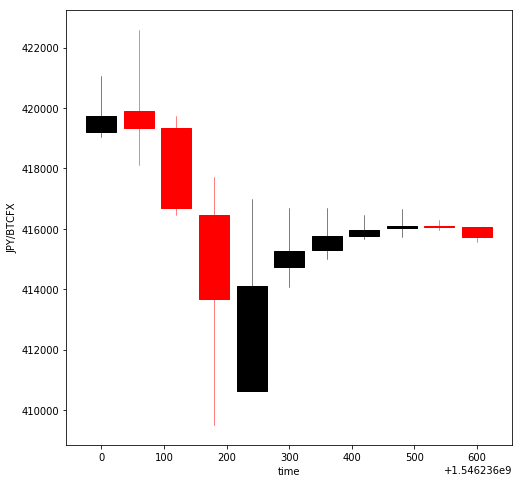

In [163]:
import matplotlib.pyplot as plt
from mpl_finance import candlestick_ohlc
%matplotlib inline

timestamps = ohlcv["time"].as_matrix()


# candle stick
fig, axes = plt.subplots(figsize=(8, 8))
_ = candlestick_ohlc(axes, ohlcv[["time", "open", "high", "low", "close"]].values, width=np.diff(timestamps)[0]*0.8)
plt.ylabel("JPY/BTCFX")
plt.xlabel("time")